# Text-summarizer

## Libraries

In [1]:
"""
#!pip install tensorflow==2.18.0
#!pip install keras==3.7.0
"""
import tensorflow as tf

import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

from tensorflow.keras.callbacks import EarlyStopping
import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


GDRIVE_PATH = ""
"""
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE_PATH="/content/gdrive/MyDrive/Colab Notebooks/dasalvare/"
"""

2025-02-25 18:28:39.972688: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 18:28:39.981295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740504519.991788  132596 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740504519.994747  132596 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 18:28:40.005546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

'\n# mount drive\nfrom google.colab import drive\ndrive.mount(\'/content/gdrive\')\nGDRIVE_PATH="/content/gdrive/MyDrive/Colab Notebooks/dasalvare/"\n'

## Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

data = pd.read_csv(f"{path}/Reviews.csv", nrows=100000)  # reading only 100k rows

data.drop_duplicates(subset=["Text"], inplace=True)  # dropping duplicates
data.dropna(axis=0, inplace=True)  # dropping na
data.info()

Path to dataset files: /home/enrico/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2
<class 'pandas.core.frame.DataFrame'>
Index: 88419 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88419 non-null  int64 
 1   ProductId               88419 non-null  object
 2   UserId                  88419 non-null  object
 3   ProfileName             88419 non-null  object
 4   HelpfulnessNumerator    88419 non-null  int64 
 5   HelpfulnessDenominator  88419 non-null  int64 
 6   Score                   88419 non-null  int64 
 7   Time                    88419 non-null  int64 
 8   Summary                 88419 non-null  object
 9   Text                    88419 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


### Preprocessing
Preprocessing steps:
- Convert everything in lowercase
- remove html tags
- contraction mapping
- remove 's
- remove any text inside "()"
- elimante punctation and special chars
- remove stopwords
- remove short words

In [3]:
contraction_mapping = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

In [4]:
import nltk

# Download stopwords if not already downloaded
nltk.download("stopwords")

STOP_WORDS = set(stopwords.words("english"))  # set of stopwords


def clean_text(input_text, remove_stopwords):
    """
    This function cleans the input text based on the following steps:
    - Lowercase the text
    - Remove HTML tags
    - Remove quotes and parentheses content
    - Replace contractions
    - Remove 's
    - Remove any non-alphanumeric characters
    - Normalize multiple letter repetitions (mmmm -> mm)
    - Tokenize the text
    - Remove stopwords
    - Remove words with length <= 1

    Args:
        input_text (str): To clean text.
        remove_stopwords (bool): If True, remove stopwords.

    Returns:
        str: Clean text.
    """

    # Lowercase
    cleaned_text = input_text.lower()

    # Remove HTML tags
    cleaned_text = BeautifulSoup(cleaned_text, "html.parser").text

    # Remove quotes and parentheses content
    cleaned_text = re.sub(r"\([^)]*\)", "", cleaned_text)
    cleaned_text = re.sub('"', "", cleaned_text)

    # Replace contractions
    cleaned_text = " ".join(
        [
            contraction_mapping[word] if word in contraction_mapping else word
            for word in cleaned_text.split()
        ]
    )

    # Remove 's
    cleaned_text = re.sub(r"'s\\b", "", cleaned_text)

    # Remove any non-alphanumeric characters
    cleaned_text = re.sub(r"[^a-zA-Z]", " ", cleaned_text)

    # Normalize multiple letter repetitions
    cleaned_text = re.sub(
        r"[m]{2,}", "mm", cleaned_text
    )  # Since it's a food review dataset there coulde be words mmm mmmm etc.

    # Tokenizzation
    tokens = cleaned_text.split()

    # Remove stopwords
    if remove_stopwords:
        tokens = [word for word in tokens if word not in STOP_WORDS]

    # Remove words with length <= 1
    filtered_tokens = [word for word in tokens if len(word) > 1]

    # Join tokens back to string
    return " ".join(filtered_tokens).strip()

[nltk_data] Downloading package stopwords to /home/enrico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Clean text
cleaned_text = [clean_text(text, remove_stopwords=True) for text in data["Text"]]

# Clean summary
cleaned_summary = [
    clean_text(summary, remove_stopwords=False) for summary in data["Summary"]
]

In [6]:
# Add cleaned text and summary to the dataframe
data["cleaned_text"] = cleaned_text
data["cleaned_summary"] = cleaned_summary

# Substituting empty strings with NaN
data.replace("", np.nan, inplace=True)

# Dropping rows with NaN values
data.dropna(axis=0, inplace=True)

In [7]:
data["cleaned_text"].head()
data["cleaned_summary"].head()

0    good quality dog food
1        not as advertised
2      delight says it all
3           cough medicine
4              great taffy
Name: cleaned_summary, dtype: object

### Distribuition of the sentences

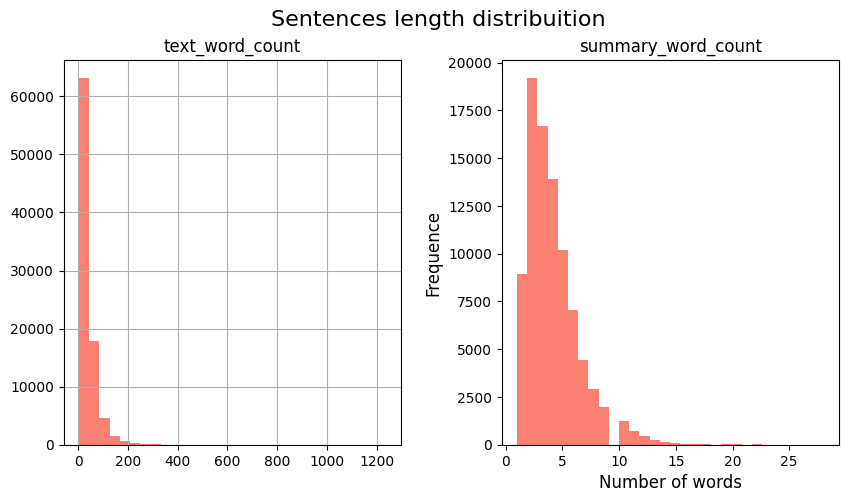

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the length of the text and summary
data["text_word_count"] = data["cleaned_text"].apply(lambda x: len(x.split()))
data["summary_word_count"] = data["cleaned_summary"].apply(lambda x: len(x.split()))

# Dataframe with text and summary length
length_df = data[["text_word_count", "summary_word_count"]]

# Plot
length_df.hist(bins=30, figsize=(10, 5), color=["salmon"])
plt.suptitle("Sentences length distribuition", fontsize=16)
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequence", fontsize=12)
plt.grid(False)

plt.savefig(
        f"{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}{GDRIVE_PATH}results/media/graphs/dataset_length_distribuition", dpi=300, bbox_inches="tight"
    )

plt.show()

### Only select reviews and summaries that follows some constraints

In [9]:
max_text_len = 30  # Max length of text
max_summary_len = 8  # Max length of summary

# Count the number of words in text and summary
data["text_word_count"] = data["cleaned_text"].apply(
    lambda x: len(x.split())
)  # Count words in text
data["summary_word_count"] = data["cleaned_summary"].apply(
    lambda x: len(x.split())
)  # Count words in summary

# Filter only text and summaries that satisfy the length limits
filtered_data = data[
    (data["text_word_count"] <= max_text_len)
    & (data["summary_word_count"] <= max_summary_len)
]

# Creare un nuovo DataFrame con i dati filtrati
df = filtered_data[["cleaned_text", "cleaned_summary"]].rename(
    columns={"cleaned_text": "text", "cleaned_summary": "summary"}
)

# Visualize dataframe
df.head()

text  \
0                                     bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better   
1                                                                    product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo   
3                                                                              looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal   
4                                                                                                                      great taffy great price wide assortment yummy taffy delivery quick taffy lover deal   
6  saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party every...   

                                      summary  
0                       good quality dog food  
1                           not as advertised  
3                              cough medicine  
4                                 great taffy  
6  great just as good as the expensive brands

### Add START and END special tokens

In [10]:
# Add special tokens to the summary if not already present
def add_special_tokens(summary_text):
    """
    Add special tokens to the summary if not already present

    Args:
        summary_text (str): Text to modify.

    Returns:
        str: Text with special tokens.
    """
    prefix = "sostok "
    suffix = " eostok"

    # Add the prefix if not already present
    if not summary_text.startswith(prefix):
        summary_text = prefix + summary_text

    # Add the suffix if not already present
    if not summary_text.endswith(suffix):
        summary_text = summary_text + suffix

    return summary_text


# Apply the function to the summary column
df["modified_summary"] = df["summary"].apply(add_special_tokens)

# Visualize
print(df["modified_summary"].head())

0                         sostok good quality dog food eostok
1                             sostok not as advertised eostok
3                                sostok cough medicine eostok
4                                   sostok great taffy eostok
6    sostok great just as good as the expensive brands eostok
Name: modified_summary, dtype: object


### Split training and validation set

In [11]:
from sklearn.model_selection import train_test_split

x_training, x_validation, y_training, y_validation = train_test_split(
    np.array(df["text"]),
    np.array(df["modified_summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

# Print the size of the training and validation set
print(f"Training set size: {len(x_training)}")
print(f"Validation set size: {len(x_validation)}")

Training set size: 42451
Validation set size: 4717


## Tokenizers

### Rarewords
Rarewords are words that occurs less than a certain amount of time in the vocabulary

In [12]:
def calculate_rare_words_coverage(tokenizer, threshold=4):
    """
    Calculate the percentage of rare words and the coverage of rare words in the vocabulary.

    Args:
        tokenizer (Tokenizer): The tokenizer object.
        threshold (int): The threshold to consider a word as rare.

    Returns:
        dict: A dictionary containing the percentage of rare words and the coverage of rare words.
    """
    cnt = 0  # Number of rare words
    tot_cnt = 0  # Number of total words
    freq = 0  # Frequency of rare words
    tot_freq = 0  # Total frequency of all words

    for key, value in tokenizer.word_counts.items():
        tot_cnt += 1
        tot_freq += value
        if value < threshold:
            cnt += 1
            freq += value

    # Percentage of rare words
    rare_word_percentage = (cnt / tot_cnt) * 100 if tot_cnt > 0 else 0
    rare_word_coverage = (freq / tot_freq) * 100 if tot_freq > 0 else 0

    return {
        "percentage_of_rare_words": rare_word_percentage,
        "coverage_of_rare_words": rare_word_coverage,
        "cnt": cnt,
        "tot_cnt": tot_cnt,
        "freq": freq,
        "tot_freq": tot_freq,
    }



### Text-Tokenizer

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_training))

# Calculate the percentage of rare words and the coverage of rare words in the vocabulary
x_rarewords_result = calculate_rare_words_coverage(x_tokenizer, threshold=4)

# Print the result
print(f"% of rare words in vocabulary: {x_rarewords_result['percentage_of_rare_words']:.2f}%")
print(f"Total Coverage of rare words: {x_rarewords_result['coverage_of_rare_words']:.2f}%")

# Define the maximum vocabulary size
max_vocab_size = max(x_rarewords_result["tot_cnt"] - x_rarewords_result["cnt"], 1)

# Define the tokenizer with the maximum vocabulary size
x_tokenizer = Tokenizer(num_words=max_vocab_size)

# Fit the tokenizer on the training data
x_tokenizer.fit_on_texts(list(x_training))

# Calculate the percentage of rare words and the coverage of rare words in the vocabulary
x_tr_seq = x_tokenizer.texts_to_sequences(x_training)
x_val_seq = x_tokenizer.texts_to_sequences(x_validation)

# Pad the sequences
x_training_padded = pad_sequences(x_tr_seq, maxlen=max_text_len, padding="post")
x_validation_padded = pad_sequences(x_val_seq, maxlen=max_text_len, padding="post")

# Define the vocabulary size (padding token included)
x_voc = x_tokenizer.num_words + 1

# Print the vocabulary size
print(f"Vocabulary dimension (padding token included (+1)): {x_voc}")

% of rare words in vocabulary: 66.08%
Total Coverage of rare words: 2.94%
Vocabulary dimension (padding token included (+1)): 8430


### Summary-Tokenizer

In [14]:
# prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_training))

# Calculate the percentage of rare words and the coverage of rare words in the vocabulary
y_rarewords_result = calculate_rare_words_coverage(y_tokenizer, threshold=6)

# Print the result
print(f"% of rare words in vocabulary: {y_rarewords_result['percentage_of_rare_words']:.2f}%")
print(f"Total Coverage of rare words: {y_rarewords_result['coverage_of_rare_words']:.2f}%")

# Define the maximum vocabulary size
max_vocab_size = max(y_rarewords_result["tot_cnt"] - y_rarewords_result["cnt"], 1)

# Define the tokenizer with the maximum vocabulary size
y_tokenizer = Tokenizer(num_words=max_vocab_size)

# Fit the tokenizer on the training data
y_tokenizer.fit_on_texts(list(y_training))

# Calculate the percentage of rare words and the coverage of rare words in the vocabulary
y_tr_seq = y_tokenizer.texts_to_sequences(y_training)
y_val_seq = y_tokenizer.texts_to_sequences(y_validation)

# Pad the sequences
y_training_padded = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding="post")
y_validation_padded = pad_sequences(y_val_seq, maxlen=max_summary_len, padding="post")

# Define the vocabulary size (padding token included)
y_voc = y_tokenizer.num_words + 1

# Print the vocabulary size
print(f"Vocabulary dimension (padding token included (+1)): {y_voc}")


% of rare words in vocabulary: 78.26%
Total Coverage of rare words: 5.41%
Vocabulary dimension (padding token included (+1)): 1975


#### Remove rows containing only the start and end tokens

In [15]:
# Function to determine wether a sequence contains only START and END tokens
def is_only_start_end(sequence):
    return np.count_nonzero(sequence) == 2  # Count the number of non-zero elements, if only 2 then delete

# Create a mask to remove sequences that contain only START and END tokens
mask_training = [not is_only_start_end(seq) for seq in y_training_padded]
mask_validation = [not is_only_start_end(seq) for seq in y_validation_padded]

# Apply the mask to the training and validation data
x_training_padded = x_training_padded[mask_training]
y_training_padded = y_training_padded[mask_training]
x_validation_padded = x_validation_padded[mask_validation]
y_validation_padded = y_validation_padded[mask_validation]


# Verify the shape of the training and validation data
print(f"x_training shape: {x_training_padded.shape}")
print(f"y_training shape: {y_training_padded.shape}")
print(f"x_validation shape: {x_validation_padded.shape}")
print(f"y_validation shape: {y_validation_padded.shape}")


x_training shape: (41326, 30)
y_training shape: (41326, 8)
x_validation shape: (4594, 30)
y_validation shape: (4594, 8)


## Model

Il modello è Seq2Seq con attention, utilizzando LSTM come encoder e decoder. Inoltre, il modello utilizza un layer di attenzione (customizzato con AttentionLayer)

I0000 00:00:1740504530.496621  132596 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5813 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "Seq2SeqLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 30, 100)   │    843,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm1       │ [(None, 30, 300), │    481,200 │ encoder_embeddin… │
│ (LSTM)              │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm2       │ [(None, 30, 300), │    721,200 │ encoder_lstm1[1]… │
│ (LSTM)              │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 100) │    197,500 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm3       │ [(None, 30, 300), │    721,200 │ encoder_lstm2[1]… │
│ (LSTM)              │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    481,200 │ decoder_embeddin… │
│                     │ 300), (None,      │            │ encoder_lstm3[1]… │
│                     │ 300), (None,      │            │ encoder_lstm3[1]… │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, None,     │    180,300 │ encoder_lstm3[1]… │
│ (AttentionLayer)    │ 300), (None,      │            │ decoder_lstm[1][… │
│                     │ None, 30)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 600) │          0 │ decoder_lstm[1][… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │  1,186,975 │ concatenate_1[0]… │
│ (TimeDistributed)   │ 1975)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,812,575 (18.36 MB)

 Trainable params: 4,812,575 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

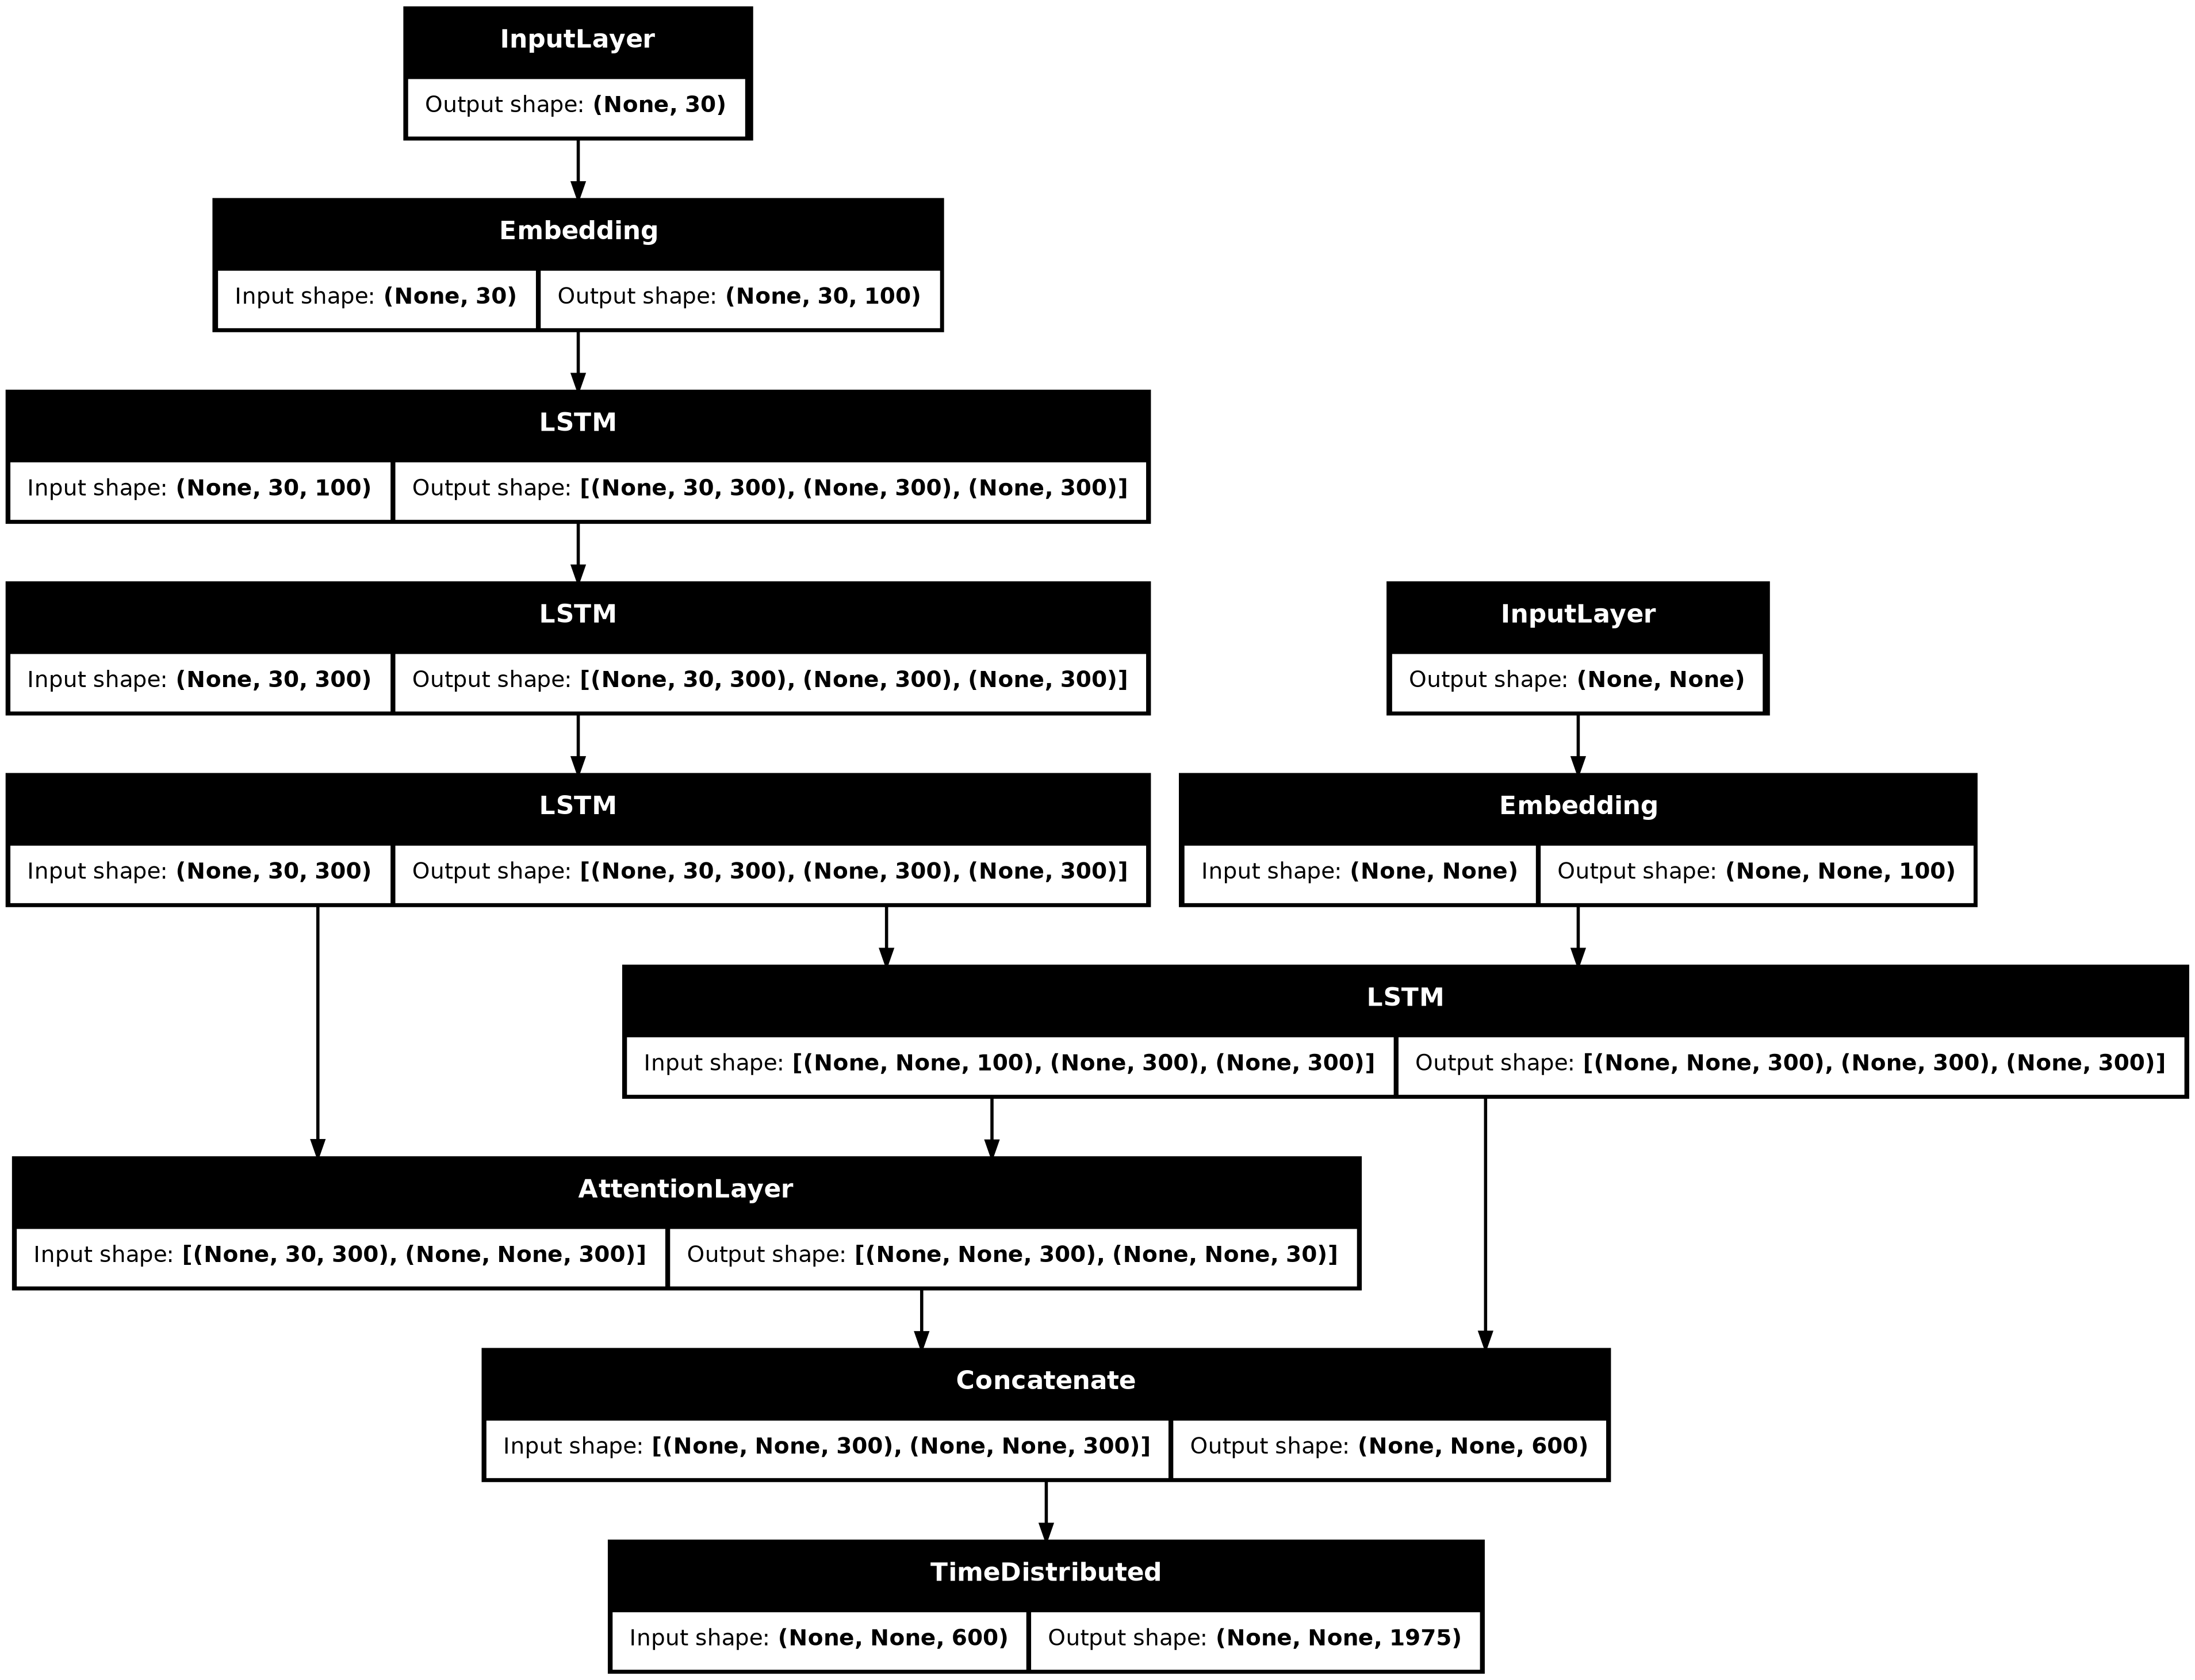

In [16]:
from keras import backend as K
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


K.clear_session()


latent_dim = 300
embedding_dim = 100
encoder_dropout = 0.3
encoder_recurrent_dropout = 0.3
decoder_dropout = 0.3
decoder_recurrent_dropout = 0.3
# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
name_additional_info = ""

# Callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=2,
    restore_best_weights=True,
)

callbacks = [early_stopping]

# Define the model

from architectures.Seq2SeqLSTM import Seq2SeqLSTM
model_instance = Seq2SeqLSTM(
    x_voc,
    y_voc,
    max_text_len,
    max_summary_len,
    x_tokenizer=x_tokenizer,
    y_tokenizer=y_tokenizer,
    name_additional_info="",
    latent_dim=latent_dim,
    embedding_dim=embedding_dim,
    encoder_dropout=encoder_dropout,
    encoder_recurrent_dropout=encoder_recurrent_dropout,
    decoder_dropout=decoder_dropout,
    decoder_recurrent_dropout=decoder_recurrent_dropout,
)

""" from architectures.Seq2SeqLSTMGlove import Seq2SeqLSTMGlove
model_instance = Seq2SeqLSTMGlove(
    x_voc,
    y_voc,
    max_text_len,
    max_summary_len,
    x_tokenizer=x_tokenizer,
    y_tokenizer=y_tokenizer,
    name_additional_info="",
    latent_dim=latent_dim,
    embedding_dim=embedding_dim,
    encoder_dropout=encoder_dropout,
    encoder_recurrent_dropout=encoder_recurrent_dropout,
    decoder_dropout=decoder_dropout,
    decoder_recurrent_dropout=decoder_recurrent_dropout,
) """

""" from architectures.Seq2SeqBiLSTM import Seq2SeqBiLSTM
model_instance = Seq2SeqBiLSTM(
    x_voc,
    y_voc,
    max_text_len,
    max_summary_len,
    x_tokenizer=x_tokenizer,
    y_tokenizer=y_tokenizer,
    name_additional_info="",
    latent_dim=latent_dim,
    embedding_dim=embedding_dim,
    encoder_dropout=encoder_dropout,
    encoder_recurrent_dropout=encoder_recurrent_dropout,
    decoder_dropout=decoder_dropout,
    decoder_recurrent_dropout=decoder_recurrent_dropout,
) """

""" from architectures.Seq2Seq3BiLSTM import Seq2Seq3BiLSTM
model_instance = Seq2Seq3BiLSTM(
    x_voc,
    y_voc,
    max_text_len,
    max_summary_len,
    x_tokenizer=x_tokenizer,
    y_tokenizer=y_tokenizer,
    name_additional_info="",
    latent_dim=latent_dim,
    embedding_dim=embedding_dim,
    encoder_dropout=encoder_dropout,
    encoder_recurrent_dropout=encoder_recurrent_dropout,
    decoder_dropout=decoder_dropout,
    decoder_recurrent_dropout=decoder_recurrent_dropout,
) """

""" from architectures.Seq2SeqLSTMTransformer import Seq2SeqLSTMTransformer
model_instance = Seq2SeqLSTMTransformer(
    x_voc,
    y_voc,
    max_text_len,
    max_summary_len,
    x_tokenizer=x_tokenizer,
    y_tokenizer=y_tokenizer,
    name_additional_info="",
    latent_dim=latent_dim,
    embedding_dim=embedding_dim,
    encoder_dropout=encoder_dropout,
    encoder_recurrent_dropout=encoder_recurrent_dropout,
    decoder_dropout=decoder_dropout,
    decoder_recurrent_dropout=decoder_recurrent_dropout,
) """

"""
from architectures.Seq2SeqGRU import Seq2SeqGRU

model_instance = Seq2SeqGRU(
    x_voc,
    y_voc,
    max_text_len,
    max_summary_len,
    x_tokenizer=x_tokenizer,
    y_tokenizer=y_tokenizer,
    latent_dim=latent_dim,
    embedding_dim=embedding_dim,
    encoder_dropout=encoder_dropout,
    encoder_recurrent_dropout=encoder_recurrent_dropout,
    decoder_dropout=decoder_dropout,
    decoder_recurrent_dropout=decoder_recurrent_dropout,
)
"""

model_instance.change_optimizer(optimizer)
model_instance.add_callbacks(callbacks)

model = model_instance.get_model()

model.summary()

plot_model(
    model,
    to_file=f"{GDRIVE_PATH}results/media/architectures/{model.name}_image.png",
    show_shapes=True,
)

# You should install pydot and graphviz to plot the model

from IPython.display import Image, display


display(Image(f"{GDRIVE_PATH}results/media/architectures/{model.name}_image.png"))

## Training

In [17]:
EPOCHS = 50
BATCH_SIZE = 128


TO_TRAIN = True
TO_LOAD_WEIGHTS = False
WEIGHTS_NAME = f"{model_instance.name}"

if TO_TRAIN:
    history = model.fit(
        [x_training_padded, y_training_padded[:, :-1]],
        y_training_padded.reshape(
            y_training_padded.shape[0], y_training_padded.shape[1], 1
        )[:, 1:],
        epochs=EPOCHS,
        callbacks=model_instance.get_callbacks(),
        batch_size=BATCH_SIZE,
        validation_data=(
            [x_validation_padded, y_validation_padded[:, :-1]],
            y_validation_padded.reshape(
                y_validation_padded.shape[0], y_validation_padded.shape[1], 1
            )[:, 1:],
        ),
    )  # training

if TO_LOAD_WEIGHTS:
    if WEIGHTS_NAME != model_instance.name:
        # Load custom weights
        print(f"Loading weights from {WEIGHTS_NAME}.weights.h5")
        model.load_weights(f"{GDRIVE_PATH}results/weights/{WEIGHTS_NAME}.weights.h5")
    else:
        # Load weights from model
        print(f"Loading weights from {model_instance.name}.weights.h5")
        model.load_weights(
            f"{GDRIVE_PATH}results/weights/{model_instance.name}.weights.h5"
        )

Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.5331 - loss: 3.3447 - val_accuracy: 0.6008 - val_loss: 2.5809
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.5974 - loss: 2.5780 - val_accuracy: 0.6108 - val_loss: 2.4604
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.6072 - loss: 2.4569 - val_accuracy: 0.6174 - val_loss: 2.3641
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.6167 - loss: 2.3367 - val_accuracy: 0.6243 - val_loss: 2.2762
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6226 - loss: 2.2281 - val_accuracy: 0.6307 - val_loss: 2.1823
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6292 - loss: 2.1297 - val_accuracy: 0.6369 - val_loss: 2.1304
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6349 - loss: 2.0443 - val_accuracy: 0.6382 - val_loss: 2.0965
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6402 - loss: 1.9735 - 

## Plot
### Plot the loss and validation loss

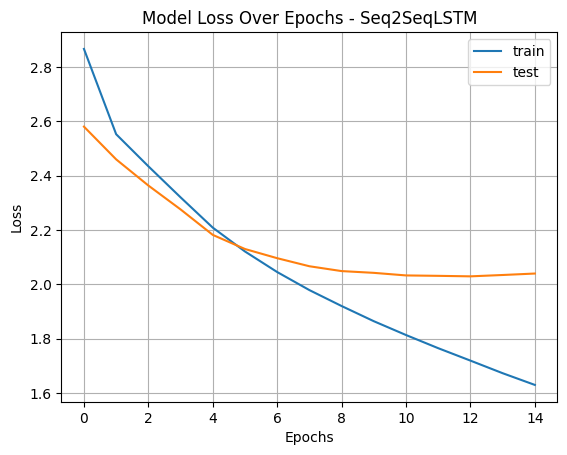

In [18]:
from matplotlib import pyplot as plt

if TO_TRAIN:
    # Plot training and validation loss
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend()
    plt.title(f"Model Loss Over Epochs - {model_instance.name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

    # Save the plot to a file
    plt.savefig(f"{GDRIVE_PATH}results/media/graphs/{model.name}_originale_lossplot", dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

## Save Model

In [19]:
TO_SAVE = True
TO_SAVE_FULL_MODEL = True

if TO_SAVE:
    # Save the model weights
    model.save_weights(f"{GDRIVE_PATH}results/weights/{model.name}.weights.h5")
    if TO_SAVE_FULL_MODEL:
        # Save the full model
        model.save(f"{GDRIVE_PATH}results/weights/{model.name}_full_model.h5")

## Inference

In [20]:
NUMBER_OF_INFERENCES = 5

for i in range(0, NUMBER_OF_INFERENCES):
    print("Review:", model_instance.seq2text(x_training_padded[i]))
    print("Original summary:", model_instance.seq2summary(y_training_padded[i]))
    print("Predicted summary:", model_instance.decode_sequence(x_training_padded[i].reshape(1, max_text_len)))
    print("\n")

Review: daughter used quaker instant oatmeal liked lot long time ago tried version like fact want finish sure maybe lots new ingredients artificial
Original summary: not very good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted summary:  great product


Review: liked coffee much subscribing dark rich smooth
Original summary: makes great cup of java
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted summary:  good coffee


Review: like fool ordered box instead bag try disgusting smell like dead fish rinsed rinsed still smelled right light even look purple crack cannot believe stupid buy
Original summary: gross
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted summary:  yuck


Review: flavorf

## Metrics and Results

In [27]:
# Generate summaries

import os

NUMBER_OF_SUMMARIES = 1000
TO_LOAD_SUMMARIES = True
TO_SAVE_SUMMARIES = True
TO_SAVE_METRICS_RESULTS = True
METRICS_TO_EVALUATE = ["rouge", "bleu", "meteor", "wer", "cosine_similarity"]

# Reset df
df_summaries = None


def generate_summaries(n_summaries=NUMBER_OF_SUMMARIES):
    """
    Generate summaries using the model.

    Returns:
        list: List of summaries.
    """
    summaries = []
    for i in range(0, n_summaries):
        summaries.append(
            model_instance.decode_sequence(
                x_training_padded[i].reshape(1, max_text_len)
            )
        )

    df_summaries = pd.DataFrame(
        {
            "original_text": [
                model_instance.seq2text(x_training_padded[i])
                for i in range(0, NUMBER_OF_SUMMARIES)
            ],
            "original_summary": [
                model_instance.seq2summary(y_training_padded[i])
                for i in range(0, NUMBER_OF_SUMMARIES)
            ],
            "predicted_summary": summaries,
        }
    )

    return df_summaries


if TO_LOAD_SUMMARIES:
    # Check if the file exists
    if not os.path.isfile(f"{GDRIVE_PATH}results/csv/{model.name}_summaries.csv"):
        print(
            f"File {GDRIVE_PATH}results/csv/{model.name}_summaries.csv not found. Generating summaries..."
        )
        df_summaries = generate_summaries()
    else:
        # Load the dataframe with the original and predicted summaries
        df_summaries = pd.read_csv(
            f"{GDRIVE_PATH}results/csv/{model.name}_summaries.csv"
        )
else:  # Generate summaries
    df_summaries = generate_summaries()

print(df_summaries.head())

if TO_SAVE_SUMMARIES:
    # Save the dataframe to a csv file
    df_summaries.to_csv(
        f"{GDRIVE_PATH}results/csv/{model.name}_summaries.csv", index=False
    )

File results/csv/Seq2SeqLSTM_summaries.csv not found. Generating summaries...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━

### ROUGE

In [28]:
def print_rouge_scores(df, print_only_if_not_all_scores_are_zero=False):
    # Calculate the total number of rows in the dataframe
    total_rows = len(df)

    # Initialize counters for rows with non-zero ROUGE scores
    rows_with_non_zero_scores = 0
    rows_with_non_zero_rouge1 = 0
    rows_with_non_zero_rouge2 = 0
    rows_with_non_zero_rougeL = 0

    # Loop through the dataframe to calculate ROUGE scores
    for index, row in df.iterrows():
        # Extract ROUGE scores for the current row
        rouge_scores = row["rouge_scores"]
        rouge_1 = rouge_scores["rouge1"]
        rouge_2 = rouge_scores["rouge2"]
        rouge_L = rouge_scores["rougeL"]

        # Check if any ROUGE score is greater than zero
        if rouge_1.fmeasure > 0 or rouge_2.fmeasure > 0 or rouge_L.fmeasure > 0:
            rows_with_non_zero_scores += 1
            if rouge_1.fmeasure > 0:
                rows_with_non_zero_rouge1 += 1
            if rouge_2.fmeasure > 0:
                rows_with_non_zero_rouge2 += 1
            if rouge_L.fmeasure > 0:
                rows_with_non_zero_rougeL += 1

    # Print a summary of the total number of rows and rows with non-zero ROUGE scores
    print(f"Total number of rows: {total_rows}")
    print(f"Rows with at least one non-zero ROUGE score: {rows_with_non_zero_scores}")
    print(f"Rows with at least one non-zero ROUGE-1: {rows_with_non_zero_rouge1}")
    print(f"Rows with at least one non-zero ROUGE-2: {rows_with_non_zero_rouge2}")
    print(f"Rows with at least one non-zero ROUGE-L: {rows_with_non_zero_rougeL}")
    print("-" * 80)

    # Print detailed summaries for each row with non-zero ROUGE scores, if the flag is set
    for index, row in df.iterrows():
        # Extract ROUGE scores for the current row
        rouge_scores = row["rouge_scores"]
        rouge_1 = rouge_scores["rouge1"]
        rouge_2 = rouge_scores["rouge2"]
        rouge_L = rouge_scores["rougeL"]

        # If the flag is set, print only rows with at least one non-zero ROUGE score
        if print_only_if_not_all_scores_are_zero and (
            rouge_1.fmeasure > 0 or rouge_2.fmeasure > 0 or rouge_L.fmeasure > 0
        ):
            print(f"Summary {index + 1}:")
            print(f"Original: {row['original_summary']}")
            print(f"Predicted: {row['predicted_summary']}")
            print(
                f"ROUGE-1: {rouge_1.fmeasure:.4f}, ROUGE-2: {rouge_2.fmeasure:.4f}, ROUGE-L: {rouge_L.fmeasure:.4f}"
            )
            print("-" * 80)


from rouge_score import rouge_scorer

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)


# Function to compute ROUGE scores for each pair of predicted and original summaries
def compute_rouge_scores(row):
    predicted = row["predicted_summary"]
    original = row["original_summary"]
    return scorer.score(original, predicted)


if METRICS_TO_EVALUATE.__contains__("rouge") == False:
    print("Skipping ROUGE evaluation")
else:

    # Apply the function to calculate ROUGE scores for each row in the dataframe
    df_summaries["rouge_scores"] = df_summaries.apply(compute_rouge_scores, axis=1)

    print("-------- ROUGE --------")
    # Print the ROUGE scores
    print_rouge_scores(df_summaries, print_only_if_not_all_scores_are_zero=True)

-------- ROUGE --------
Total number of rows: 1000
Rows with at least one non-zero ROUGE score: 326
Rows with at least one non-zero ROUGE-1: 326
Rows with at least one non-zero ROUGE-2: 64
Rows with at least one non-zero ROUGE-L: 326
--------------------------------------------------------------------------------
Summary 5:
Original: very good
Predicted:  not good
ROUGE-1: 0.5000, ROUGE-2: 0.0000, ROUGE-L: 0.5000
--------------------------------------------------------------------------------
Summary 9:
Original: cats could not eat it
Predicted:  my cats love this
ROUGE-1: 0.2222, ROUGE-2: 0.0000, ROUGE-L: 0.2222
--------------------------------------------------------------------------------
Summary 15:
Original: great wake up taste
Predicted:  great coffee
ROUGE-1: 0.3333, ROUGE-2: 0.0000, ROUGE-L: 0.3333
--------------------------------------------------------------------------------
Summary 16:
Original: great fast service and great product
Predicted:  great product
ROUGE-1: 0.5000

### BLEU

### METEOR

### Word Error Rate (WER)

In [29]:
def print_wer_scores(df, print_only_if_not_all_scores_are_zero=False):
    # Calculate the total number of rows in the dataframe
    total_rows = len(df)

    # Initialize counters for rows with non-zero WER scores
    rows_with_non_zero_scores = 0

    # Loop through the dataframe to calculate WER scores
    for index, row in df.iterrows():
        # Extract WER score for the current row
        wer_score = row["wer_scores"]

        # Check if the WER score is greater than zero
        if wer_score > 0:
            rows_with_non_zero_scores += 1

    # Print a summary of the total number of rows and rows with non-zero WER scores
    print(f"Total number of rows: {total_rows}")
    print(f"Rows with at least one non-zero WER score: {rows_with_non_zero_scores}")
    print(f"Mean WER: {df['wer_scores'].mean():.4f}")
    print("-" * 80)

    # Print detailed summaries for each row with non-zero WER scores, if the flag is set
    for index, row in df.iterrows():
        # Extract WER score for the current row
        wer_score = row["wer_scores"]

        # If the flag is set, print only rows with at least one non-zero WER score
        if print_only_if_not_all_scores_are_zero and wer_score > 0:
            print(f"Summary {index + 1}:")
            print(f"Original: {row['original_summary']}")
            print(f"Predicted: {row['predicted_summary']}")
            print(f"WER: {wer_score:.4f}")
            print("-" * 80)


from jiwer import wer


# Function to compute WER scores for each pair of predicted and original summaries
def compute_wer_scores(row):
    predicted = row["predicted_summary"]
    original = row["original_summary"]
    return wer(original, predicted)


if METRICS_TO_EVALUATE.__contains__("wer") == False:
    print("Skipping WER evaluation")
else:

    # Apply the function to calculate WER scores for each row in the dataframe
    df_summaries["wer_scores"] = df_summaries.apply(compute_wer_scores, axis=1)

    print("-------- WER --------")
    print_wer_scores(df_summaries, print_only_if_not_all_scores_are_zero=False)

-------- WER --------
Total number of rows: 1000
Rows with at least one non-zero WER score: 963
Mean WER: 1.0716
--------------------------------------------------------------------------------


### Cosine Similarity

In [30]:
def print_cosine_similarity_scores(df, print_only_if_not_all_scores_are_zero=False):
    # Calculate the total number of rows in the dataframe
    total_rows = len(df)

    # Initialize counters for rows with non-zero cosine similarity scores
    rows_with_non_zero_scores = 0

    # Loop through the dataframe to calculate cosine similarity scores
    for index, row in df.iterrows():
        # Extract cosine similarity score for the current row
        cosine_similarity_score = row["cosine_similarity"]

        # Check if the cosine similarity score is greater than zero
        if cosine_similarity_score > 0:
            rows_with_non_zero_scores += 1

    # Print a summary of the total number of rows and rows with non-zero cosine similarity scores
    print(f"Total number of rows: {total_rows}")
    print(
        f"Rows with at least one non-zero cosine similarity score: {rows_with_non_zero_scores}"
    )
    print(f"Mean cosine similarity: {df['cosine_similarity'].mean():.4f}")
    # Print top rows with the highest cosine similarity scores
    N_ROWS = 5
    print(f"Top {N_ROWS} rows with the highest cosine similarity scores:")
    print(
        df.nlargest(N_ROWS, "cosine_similarity")[
            ["original_summary", "predicted_summary", "cosine_similarity"]
        ]
    )
    print("-" * 80)

    # Print detailed summaries for each row with non-zero cosine similarity scores, if the flag is set
    for index, row in df.iterrows():
        # Extract cosine similarity score for the current row
        cosine_similarity_score = row["cosine_similarity"]

        # If the flag is set, print only rows with at least one non-zero cosine similarity score
        if print_only_if_not_all_scores_are_zero and cosine_similarity_score > 0:
            print(f"Summary {index + 1}:")
            print(f"Original: {row['original_summary']}")
            print(f"Predicted: {row['predicted_summary']}")
            print(f"Cosine similarity: {cosine_similarity_score:.4f}")
            print(f"{df}")
            print("-" * 80)


from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

if METRICS_TO_EVALUATE.__contains__("cosine_similarity") == False:
    print("Skipping cosine similarity evaluation")
else:
    sentenceModel = SentenceTransformer("paraphrase-MiniLM-L6-v2")

    def compute_cosine_similarity(row):
        predicted = row["predicted_summary"]
        original = row["original_summary"]
        return cosine_similarity(
            sentenceModel.encode([original]), sentenceModel.encode([predicted])
        )[0][0]

    df_summaries["cosine_similarity"] = df_summaries.apply(
        compute_cosine_similarity, axis=1
    )

    print("-------- COSINE SIMILARITY --------")
    print_cosine_similarity_scores(
        df_summaries, print_only_if_not_all_scores_are_zero=True
    )

-------- COSINE SIMILARITY --------
Total number of rows: 1000
Rows with at least one non-zero cosine similarity score: 986
Mean cosine similarity: 0.4287
Top 5 rows with the highest cosine similarity scores:
    original_summary predicted_summary  cosine_similarity
73       great snack       great snack                1.0
327              fun               fun                1.0
913      great snack       great snack                1.0
164     great coffee      great coffee                1.0
165     great coffee      great coffee                1.0
--------------------------------------------------------------------------------
Summary 1:
Original: not very good
Predicted:  great product
Cosine similarity: 0.2532
                                                                                                                                                      original_text  \
0                       daughter used quaker instant oatmeal liked lot long time ago tried version like fact

### Save DataFrame of Metrics

In [31]:
# Save DF
if TO_SAVE_METRICS_RESULTS:
    # Save the dataframe with ROUGE scores to a CSV file
    df_summaries.to_csv(f"{GDRIVE_PATH}results/csv/{model.name}_metrics_scores.csv", index=False)
    print(f"Metrics results saved to {GDRIVE_PATH}results/csv/{model.name}_metrics_scores.csv")


Metrics results saved to results/csv/Seq2SeqLSTM_metrics_scores.csv


### Plot Metrics

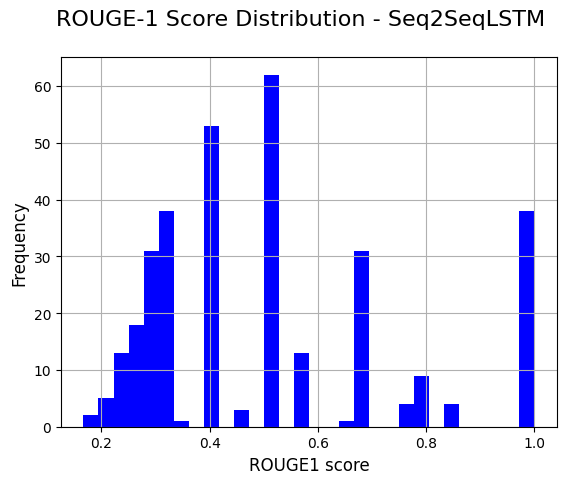

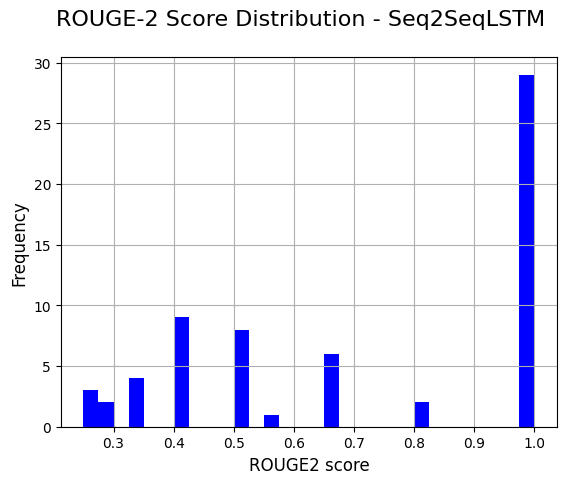

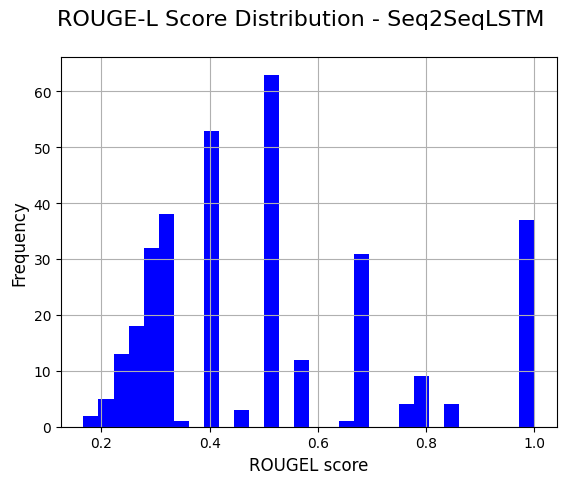

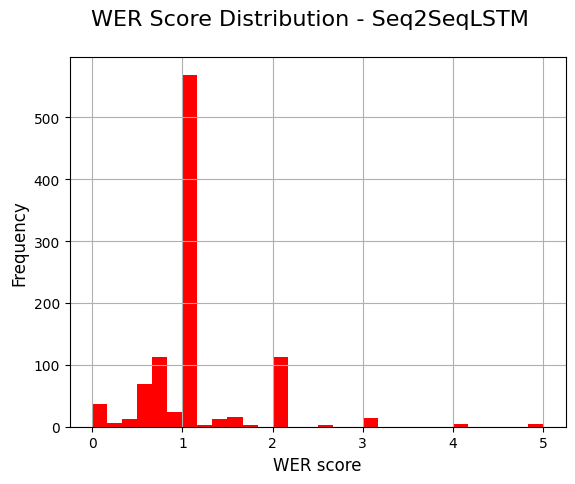

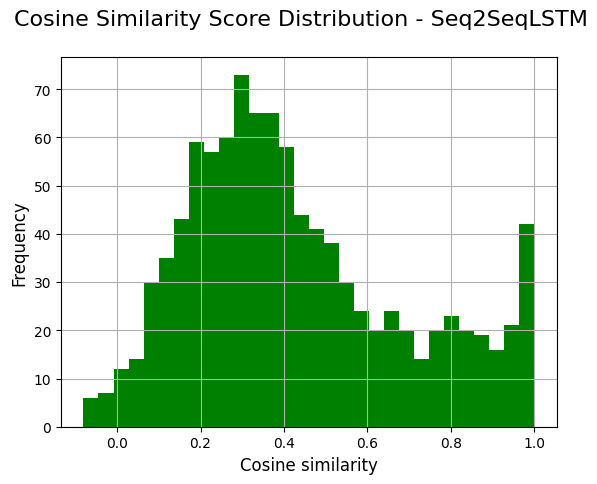

In [32]:
def plot_rouge(
    df, metric="rouge1", bins=30, remove_zeros_rows=True, color="salmon", title=None
):
    # Filter rows with all zero ROUGE scores
    if remove_zeros_rows:
        df = df[
            (df["rouge_scores"].apply(lambda x: x[metric].fmeasure) > 0)
        ]  # Filter rows with all zero ROUGE scores

    # Plot the distribution of ROUGE scores
    plt.hist(
        df["rouge_scores"].apply(lambda x: x[metric].fmeasure),
        bins=bins,
        color=color,
    )
    plt.suptitle(title or f"Distribution of {metric.upper()} scores", fontsize=16)
    plt.xlabel(f"{metric.upper()} score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True)

    # Save the plot to a file
    plt.savefig(
        f"{GDRIVE_PATH}results/media/graphs/{model.name}_{metric}_scores",
        dpi=300,
        bbox_inches="tight",
    )

    plt.show()


def plot_wer(df, bins=30, color="salmon", title=None):
    # Plot the distribution of WER scores
    plt.hist(df["wer_scores"], bins=bins, color=color)
    plt.suptitle(title or "Distribution of WER scores", fontsize=16)
    plt.xlabel("WER score", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True)

    # Save the plot to a file
    plt.savefig(
        f"{GDRIVE_PATH}results/media/graphs/{model.name}_wer_scores", dpi=300, bbox_inches="tight"
    )

    plt.show()


def plot_cosine_similarity(df, bins=30, color="salmon", title=None):
    # Plot the distribution of cosine similarity scores
    plt.hist(df["cosine_similarity"], bins=bins, color=color)
    plt.suptitle(title or "Distribution of cosine similarity scores", fontsize=16)
    plt.xlabel("Cosine similarity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True)

    # Save the plot to a file
    plt.savefig(
        f"{GDRIVE_PATH}results/media/graphs/{model.name}_cosine_similarity_scores",
        dpi=300,
        bbox_inches="tight",
    )

    plt.show()


if METRICS_TO_EVALUATE.__contains__("rouge"):
    # Plot the distribution of ROUGE-1 scores
    plot_rouge(
        df_summaries,
        metric="rouge1",
        bins=30,
        color="blue",
        title=f"ROUGE-1 Score Distribution - {model_instance.name}",
    )

    # Plot the distribution of ROUGE-2 scores
    plot_rouge(
        df_summaries,
        metric="rouge2",
        bins=30,
        color="blue",
        title=f"ROUGE-2 Score Distribution - {model_instance.name}",
    )

    # Plot the distribution of ROUGE-L scores
    plot_rouge(
        df_summaries,
        metric="rougeL",
        bins=30,
        color="blue",
        title=f"ROUGE-L Score Distribution - {model_instance.name}",
    )
if METRICS_TO_EVALUATE.__contains__("wer"):
    # Plot the distribution of WER scores
    plot_wer(df_summaries, bins=30, color="red", title=f"WER Score Distribution - {model_instance.name}")
if METRICS_TO_EVALUATE.__contains__("cosine_similarity"):
    # Plot the distribution of cosine similarity scores
    plot_cosine_similarity(
        df_summaries,
        bins=30,
        color="green",
        title=f"Cosine Similarity Score Distribution - {model_instance.name}",
    )